Simulations of a theorical setting which replicates the same results as Sinatra et al. We use here both a power law and a uniform probability distributions to generate the impact of an article (c_ten), and show that with both the 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import random, math
random.seed(100)

Global parameters for the simulations
A lognormal determines the nuber of articles published by an author. The interplay of a power law and a uniform distributions determine the number of citations received for each article.

In [2]:
N_AUTHORS = 5000 # number of authors in the simulation
CAREER_WINDOW = 20 # up to 20 the productivity is uniform over years.
PROP_PL = 0.5 # between 0 and 1. 0 all authors sample from uniform, 1 from power law. 0.5 half from each. 
#Note that each author either samples from power law or uniform, not both.

# Lognormal for number of author contributions, with the same parameters as in the article (see figure 3B, caption)
# See docs for lognorm.pdf(x, ln_sd, ln_loc, ln_mean)
ln_mean = np.exp(3.6)
ln_sd = 0.57
ln_loc = 0

# Power law
exponent = 1.2 # quite low, play with it!
max_citations_pl = 500 # max possible number of received citations

# Uniform
min_citations_u = 1
max_citations_u = 100

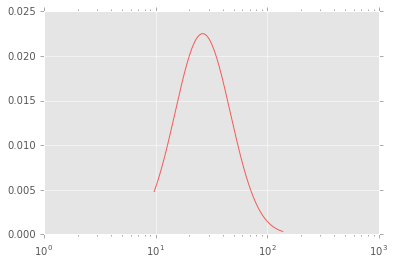

In [3]:
# inspect the lognormal
from scipy.stats import lognorm, powerlaw

x = np.linspace(lognorm.ppf(0.01, ln_sd, ln_loc, ln_mean), lognorm.ppf(0.99, ln_sd, ln_loc, ln_mean), 1000)
plt.semilogx(x, lognorm.pdf(x, ln_sd, ln_loc, ln_mean), 'r-', lw=1, alpha=0.6, label='lognorm pdf')

Power law (truncated) and uniform distributions

In [4]:
# Power law
from scipy.stats import rv_discrete

def truncated_power_law(a, m):
    x = np.arange(1, m+1, dtype='float')
    pmf = 1/x**a
    pmf /= pmf.sum()
    return rv_discrete(values=(range(1, m+1), pmf))

tpw = truncated_power_law(a=exponent, m=max_citations_pl)

# Uniform
def uniform(size):
    return [random.randint(min_citations_u,max_citations_u) for x in range(size)]

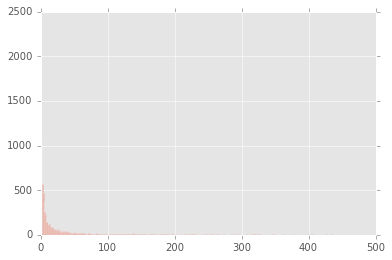

In [5]:
# example of the power law sampling
N = 10**4
sample = tpw.rvs(size=N)

plt.hist(sample, bins=np.arange(max_citations_pl)+0.5)
plt.show()

In [6]:
authors = {k:list() for k in range(N_AUTHORS)}
for a in authors.keys():
    # generate number of papers
    n_papers = math.ceil(lognorm.ppf(random.random(), ln_sd, ln_loc, ln_mean))
    # select prob distribution for incoming citations
    if random.random() <= PROP_PL:
        received_citations = np.array(tpw.rvs(size=n_papers))
    else:
        received_citations = np.array(uniform(size=n_papers))
    authors[a] = received_citations

In [7]:
# center all to max and make a vector to take means
window = 10 # before and after max
impact_array = np.zeros((1,1+(window*2)))
n_pub_array = np.zeros((1,1+(window*2)))
for a,cits in authors.items():
    m = np.argmax(cits)
    impact_array[0,window] += cits[m]
    n_pub_array[0,window] += 1
    for n in range(1,window+1):
        # before
        if m-n >= 0:
            impact_array[0,window-n] += cits[m-n]
            n_pub_array[0,window-n] += 1
        # after
        if m+n < len(cits):
            impact_array[0,window+n] += cits[m+n]
            n_pub_array[0,window+n] += 1
impact_array = np.true_divide(impact_array,n_pub_array)

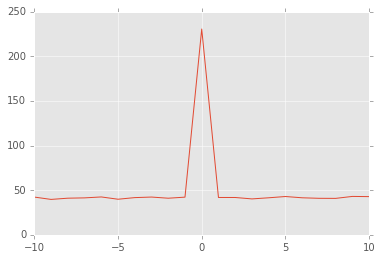

In [8]:
# cf. plot 2B
plt.plot(range(-window,window+1),impact_array[0,:])